In [1]:
#https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/
#!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
#!unzip "at&t.zip" -d .

import random, glob, os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL.ImageOps
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

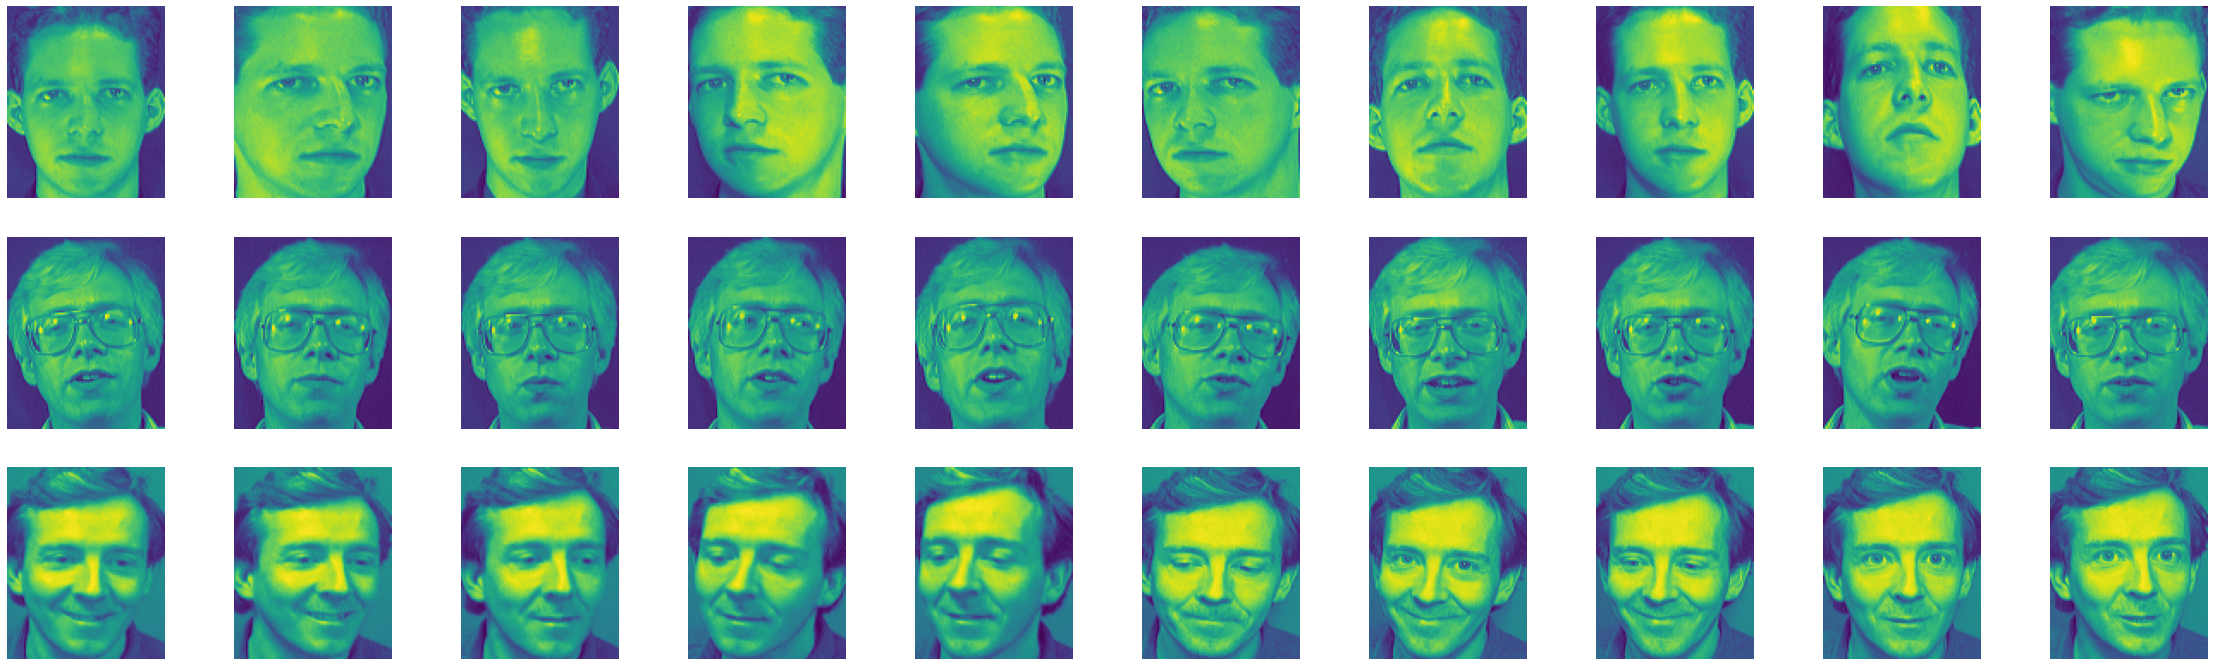

In [2]:
plt.figure(figsize=(4*10,4*3))
for i in range(1,4):
    for j in range(1,11):
        img = np.array( Image.open(f"./data/faces/training/s{i}/{j}.pgm") ) # img.shape=(112,92)
        plt.subplot(3,10,(i-1)*10+j)
        plt.imshow(img)
        plt.axis('off')
plt.show()

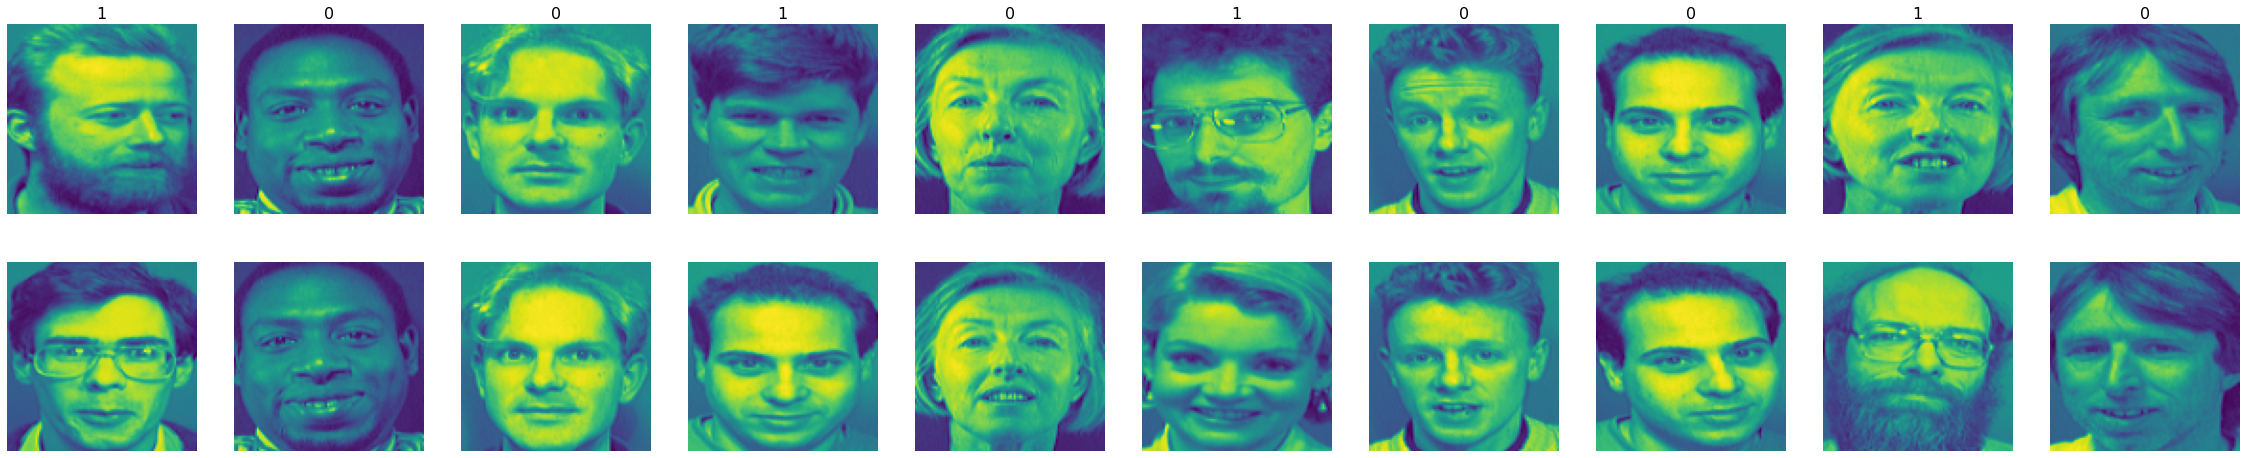

370


In [3]:
class ATTDataset(Dataset):
    def __init__(self, imgFolder):
        self.imgL = glob.glob(f"{imgFolder}/faces/training/s*/*.pgm")
        self.imgFolderL = glob.glob(f"{imgFolder}/faces/training/s*")
        self.transform = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
    
    def __len__(self):
        return len(self.imgL) # 370 since no s5,s6,s7
    
    def __getitem__(self,index=0):
        isDiff = random.randint(0,1)
        if isDiff:
            self.copyImgFolderL = self.imgFolderL[:]
            random.shuffle(self.copyImgFolderL)
            folderPath0, folderPath1 = self.copyImgFolderL[:2]
            imgPath0, imgPath1 = random.choice(glob.glob(f"{folderPath0}/*.pgm")), random.choice(glob.glob(f"{folderPath1}/*.pgm"))
        else:
            folderPath = random.choice(self.imgFolderL)
            imgPath0, imgPath1 = glob.glob(f"{folderPath}/*.pgm")[:2]
        img0, img1 = Image.open(imgPath0), Image.open(imgPath1)
        img0, img1 = self.transform(img0), self.transform(img1)
        return img0, img1, torch.Tensor([int(isDiff)])
    
    def showExample(self):
        plt.figure(figsize=(4*10,4*2))
        for i in range(10):
            img0, img1, isDiff = self.__getitem__()
            plt.subplot(2,10,i+1)
            plt.title(int(isDiff),fontsize=16)
            plt.imshow(img0.detach().numpy().reshape(100,100))
            plt.axis('off')
            plt.subplot(2,10,i+11)
            plt.imshow(img1.detach().numpy().reshape(100,100))
            plt.axis('off')
        plt.show()
        
dataset = ATTDataset("./data")
dataset.showExample()
print(len(dataset))

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2
    
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [5]:
# Load the training dataset
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=64)
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [6]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch={epoch}, Loss={loss_contrastive.item()}")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch=0, Loss=2.0599567890167236
Epoch=1, Loss=1.2989130020141602
Epoch=2, Loss=0.6864488124847412
Epoch=3, Loss=0.5205200910568237
Epoch=4, Loss=0.6095026731491089
Epoch=5, Loss=0.4377070963382721
Epoch=6, Loss=0.23451495170593262
Epoch=7, Loss=0.4548114836215973
Epoch=8, Loss=0.26620063185691833
Epoch=9, Loss=0.46828657388687134
Epoch=10, Loss=0.32671716809272766
Epoch=11, Loss=0.24164026975631714
Epoch=12, Loss=0.30267655849456787
Epoch=13, Loss=0.13720567524433136
Epoch=14, Loss=0.14876532554626465
Epoch=15, Loss=0.057442259043455124
Epoch=16, Loss=0.0909927636384964
Epoch=17, Loss=0.013196575455367565
Epoch=18, Loss=0.06337977200746536
Epoch=19, Loss=0.05446472391486168
Epoch=20, Loss=0.0793096125125885
Epoch=21, Loss=0.03770060837268829
Epoch=22, Loss=0.02007851004600525
Epoch=23, Loss=0.07012833654880524
Epoch=24, Loss=0.0192706398665905
Epoch=25, Loss=0.04829400032758713
Epoch=26, Loss=0.04901331663131714
Epoch=27, Loss=0.0199563130736351
Epoch=28, Loss=0.016634054481983185
Epo

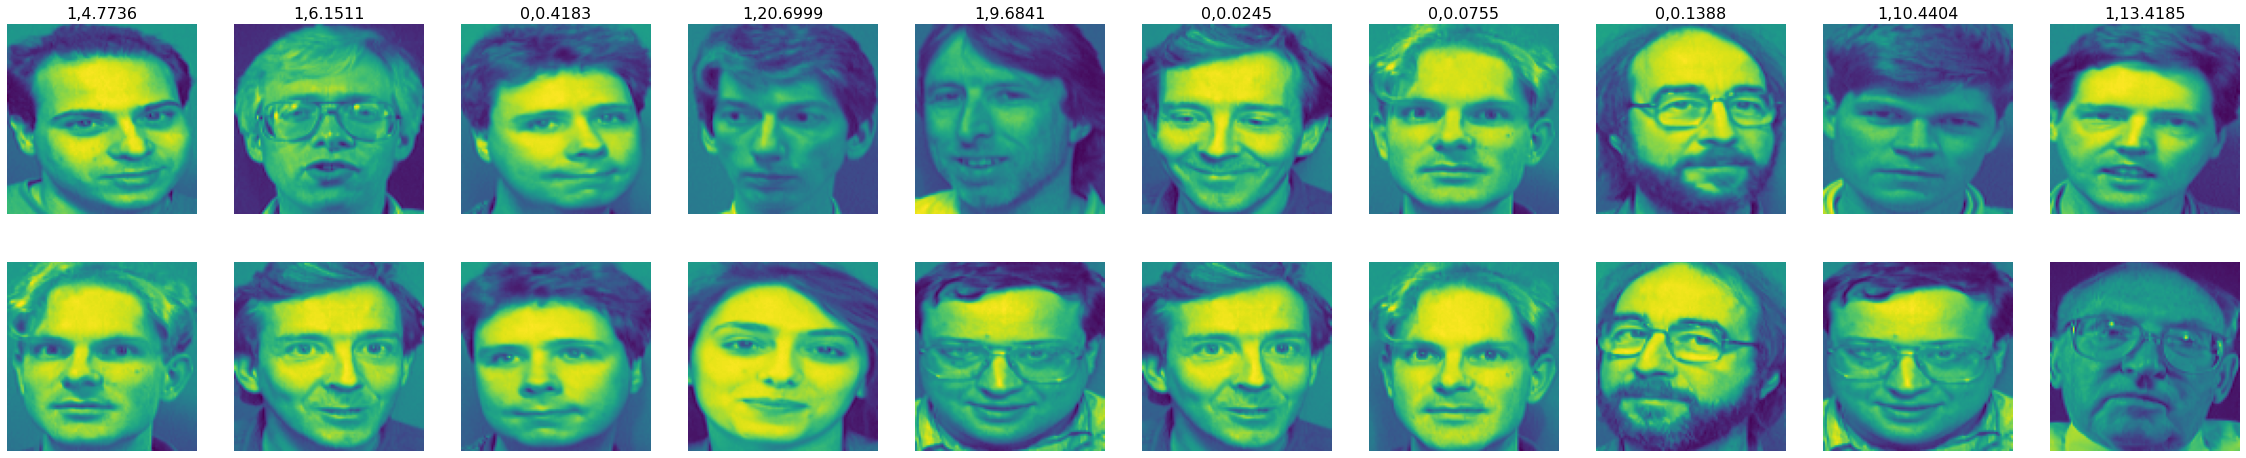

In [7]:
img0, img1, label = next(iter(train_dataloader)) # (1,100,100), (1,100,100)
output0, output1 = net(img0.to('cuda'), img1.to('cuda')) # (B,2), (B,2)
euclidean_distance = F.pairwise_distance(output0, output1) # (B,)

plt.figure(figsize=(4*10,4*2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.title(f"{int(label[i])},{round(float(euclidean_distance[i]),4)}",fontsize=16)
    plt.imshow(img0[i].detach().numpy().reshape(100,100))
    plt.axis('off')
    plt.subplot(2,10,i+11)
    plt.imshow(img1[i].detach().numpy().reshape(100,100))
    plt.axis('off')
plt.show()

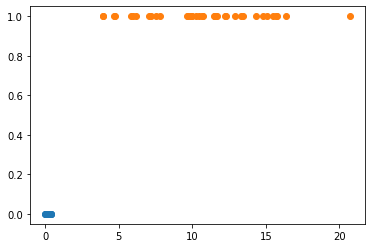

In [8]:
dis0 = []
dis1 = []
for i in range(64):
    if int(label[i])==0:
        dis0.append( float(euclidean_distance[i]) )
    else:
        dis1.append( float(euclidean_distance[i]) )

plt.scatter(dis0, [0]*len(dis0))
plt.scatter(dis1, [1]*len(dis1))
plt.show()
# best threshold followed by 1D gaussain estimation or 1D-SVM